In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk, string

# HW5
### 1 Word clouds

Let first look at some raw wordclouds. We build 2 of them:
- RawText column from the data
- ExtractedSubject and ExtractedBodyText columns concatenated

In [2]:
all_emails = pd.read_csv('hillary-clinton-emails/Emails.csv')
raw_corpus = '\n'.join(all_emails.RawText)
extracted_text = all_emails.ExtractedSubject.fillna('\n') + all_emails.ExtractedBodyText.fillna('\n')
extracted_emails = pd.DataFrame(extracted_text, columns=['Text'])
extracted_corpus = '\n'.join(extracted_emails.Text)

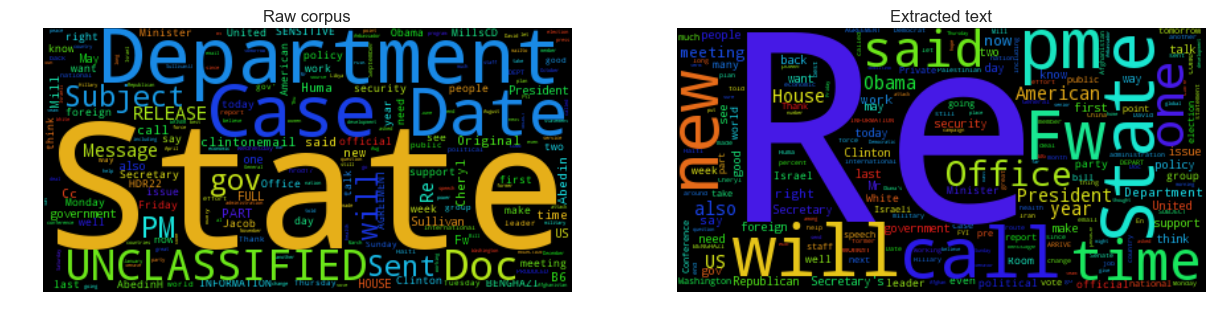

In [3]:
wordcloud = WordCloud().generate(raw_corpus)
wordcloud_extracted = WordCloud().generate(extracted_corpus)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.imshow(wordcloud)
ax1.set_title('Raw corpus')
ax1.axis('off')
ax2.imshow(wordcloud_extracted)
ax2.set_title('Extracted text')
ax2.axis('off')
plt.show()

As we can see, the RawText contains a lot of annotations (e.g. "UNCLASSIFIED U.S. Department of State Case No.").  
But the extracted text contains more short keywords (e.g. "Fw:", "Re:", etc.)

Now let create a pipeline:
- tokenize sentence and words
- remove stopwords (plus some more related to emails)
- stemming (using the Porter algorithm)

In [4]:
# Don't forget to run nltk.download() if not already done...
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def tokenize(text):
    tokenizer = RegexpTokenizer('\w+')
    return tokenizer.tokenize(text)

def remove_stopwords(words):
    # If using another tokenizer, add: ['n\'t','\'s','...','\'\'','``','--']
    stop_words = stopwords.words('english') + ['fvv','fw','fwd','re','am','pm']
    return [w.lower() for w in words if w.lower() not in stop_words]

def remove_punctuation(words):
    return [w for w in words if w not in string.punctuation]

def stemming(words):
    porter = nltk.PorterStemmer()
    return [porter.stem(w) for w in words]

def lemmantizing(words) :
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in words]

def run_pipeline(text,
                 return_as_str = False,
                 do_remove_stopwords=True, 
                 do_stemming=False,
                 do_lemmantizing=True,
                 do_remove_punctuation=True):
    words = tokenize(text)
    if do_remove_stopwords:
        words = remove_stopwords(words)
    if do_remove_punctuation:
        words = remove_punctuation(words)
    if do_stemming:
        words = stemming(words)
    if do_lemmantizing:
        words = lemmantizing(words)
    if return_as_str:
        return ' '.join(words)
    else:
        return words

In [5]:
try:
    processed_raw = np.load('processed_raw.npy').item()
    processed_extracted = np.load('processed_extracted.npy').item()
except:
    processed_raw = run_pipeline(raw_corpus, return_as_str=True)
    np.save('processed_raw', processed_raw)
    processed_extracted = run_pipeline(extracted_corpus, return_as_str=True)
    np.save('processed_extracted', processed_extracted)

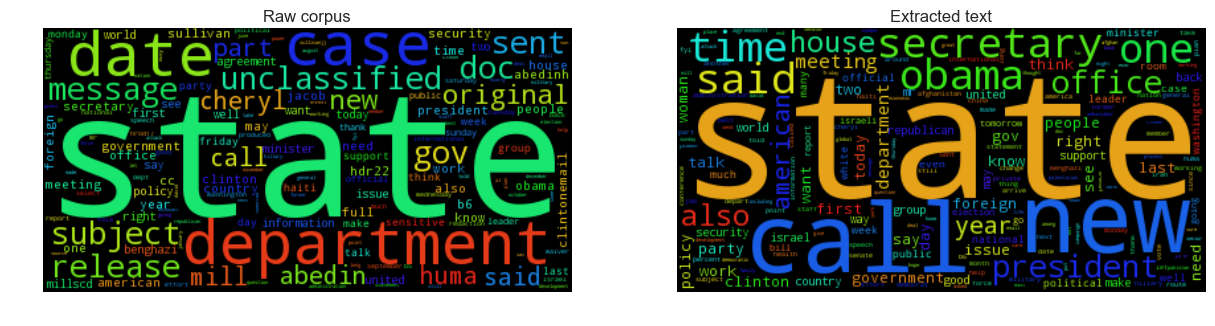

In [6]:
wordcloud = WordCloud().generate(processed_raw)
wordcloud_extracted = WordCloud().generate(processed_extracted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.imshow(wordcloud)
ax1.set_title('Raw corpus')
ax1.axis('off')
ax2.imshow(wordcloud_extracted)
ax2.set_title('Extracted text')
ax2.axis('off')
plt.show()

The two wordclouds are very close together. We also remark that the difference between Raw and Extracted is way smaller in the second approach.  
Pros and cons:  

- The first approach is much faster and straightforward but it could lack some fine grained tuning regarding language processing.  
- The second one is way slower as we run through many pre-processing steps. But its main advantage is the ability to tune some parameters (stopwords, stemming, lemmantizing, etc.).

Here, we prefer not to do stemming. Indeed, this might change considerably the country analysis as well as the sentiment analysis.

### Part 2

Finding countries in the whole corpus:

__Note:__ We only retrieve countries by their name in the Extracted dataset.  
_When trying with abbreviations we get a lot of false results because of short keywords and US appears almost everywhere._

In [7]:
from pycountry import countries

def get_country(str):
    c = None
    try:
        if len(str) > 3: # Country names are >3 letters
            c = countries.get(name=str.title()).name
    except:
        pass
    return c

def retrieve_countries(emails):
    mentioned = {}
    
    def add(country, i):
        if country in mentioned:
            mentioned[country].append(i)
        else:
            mentioned[country] = [i]
    
    for i, email in emails.iteritems():
        tokens = run_pipeline(email)
        for token in tokens:
            country = get_country(token)
            if country:
                add(country, i)
    return mentioned

try:
    mentioned2 = np.load('mentioned2.npy').item()
except:
    mentioned2 = retrieve_countries(extracted_emails.Text)
    np.save('mentioned2.npy', mentioned2)

Now we compute the polarities using NLTK vader package:

In [8]:
try:
    polarities2 = np.load('polarities2.npy')
except:
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    sid = SentimentIntensityAnalyzer()
    polarities2 = [sid.polarity_scores(email) for email in extracted_emails.Text]
    np.save('polarities2.npy', polarities2)

In [9]:
result = []
for country, emails in mentioned2.items():
    for email in set(emails):
        polarity = polarities2[email]['compound']
        result.append([country, polarity])
result = pd.DataFrame(result, columns=['Country','Polarity'])
sorted_values = result.groupby('Country').mean().sort_values(by='Polarity')
colors = ['b' if pol > 0 else 'r' for pol in sorted_values.Polarity]

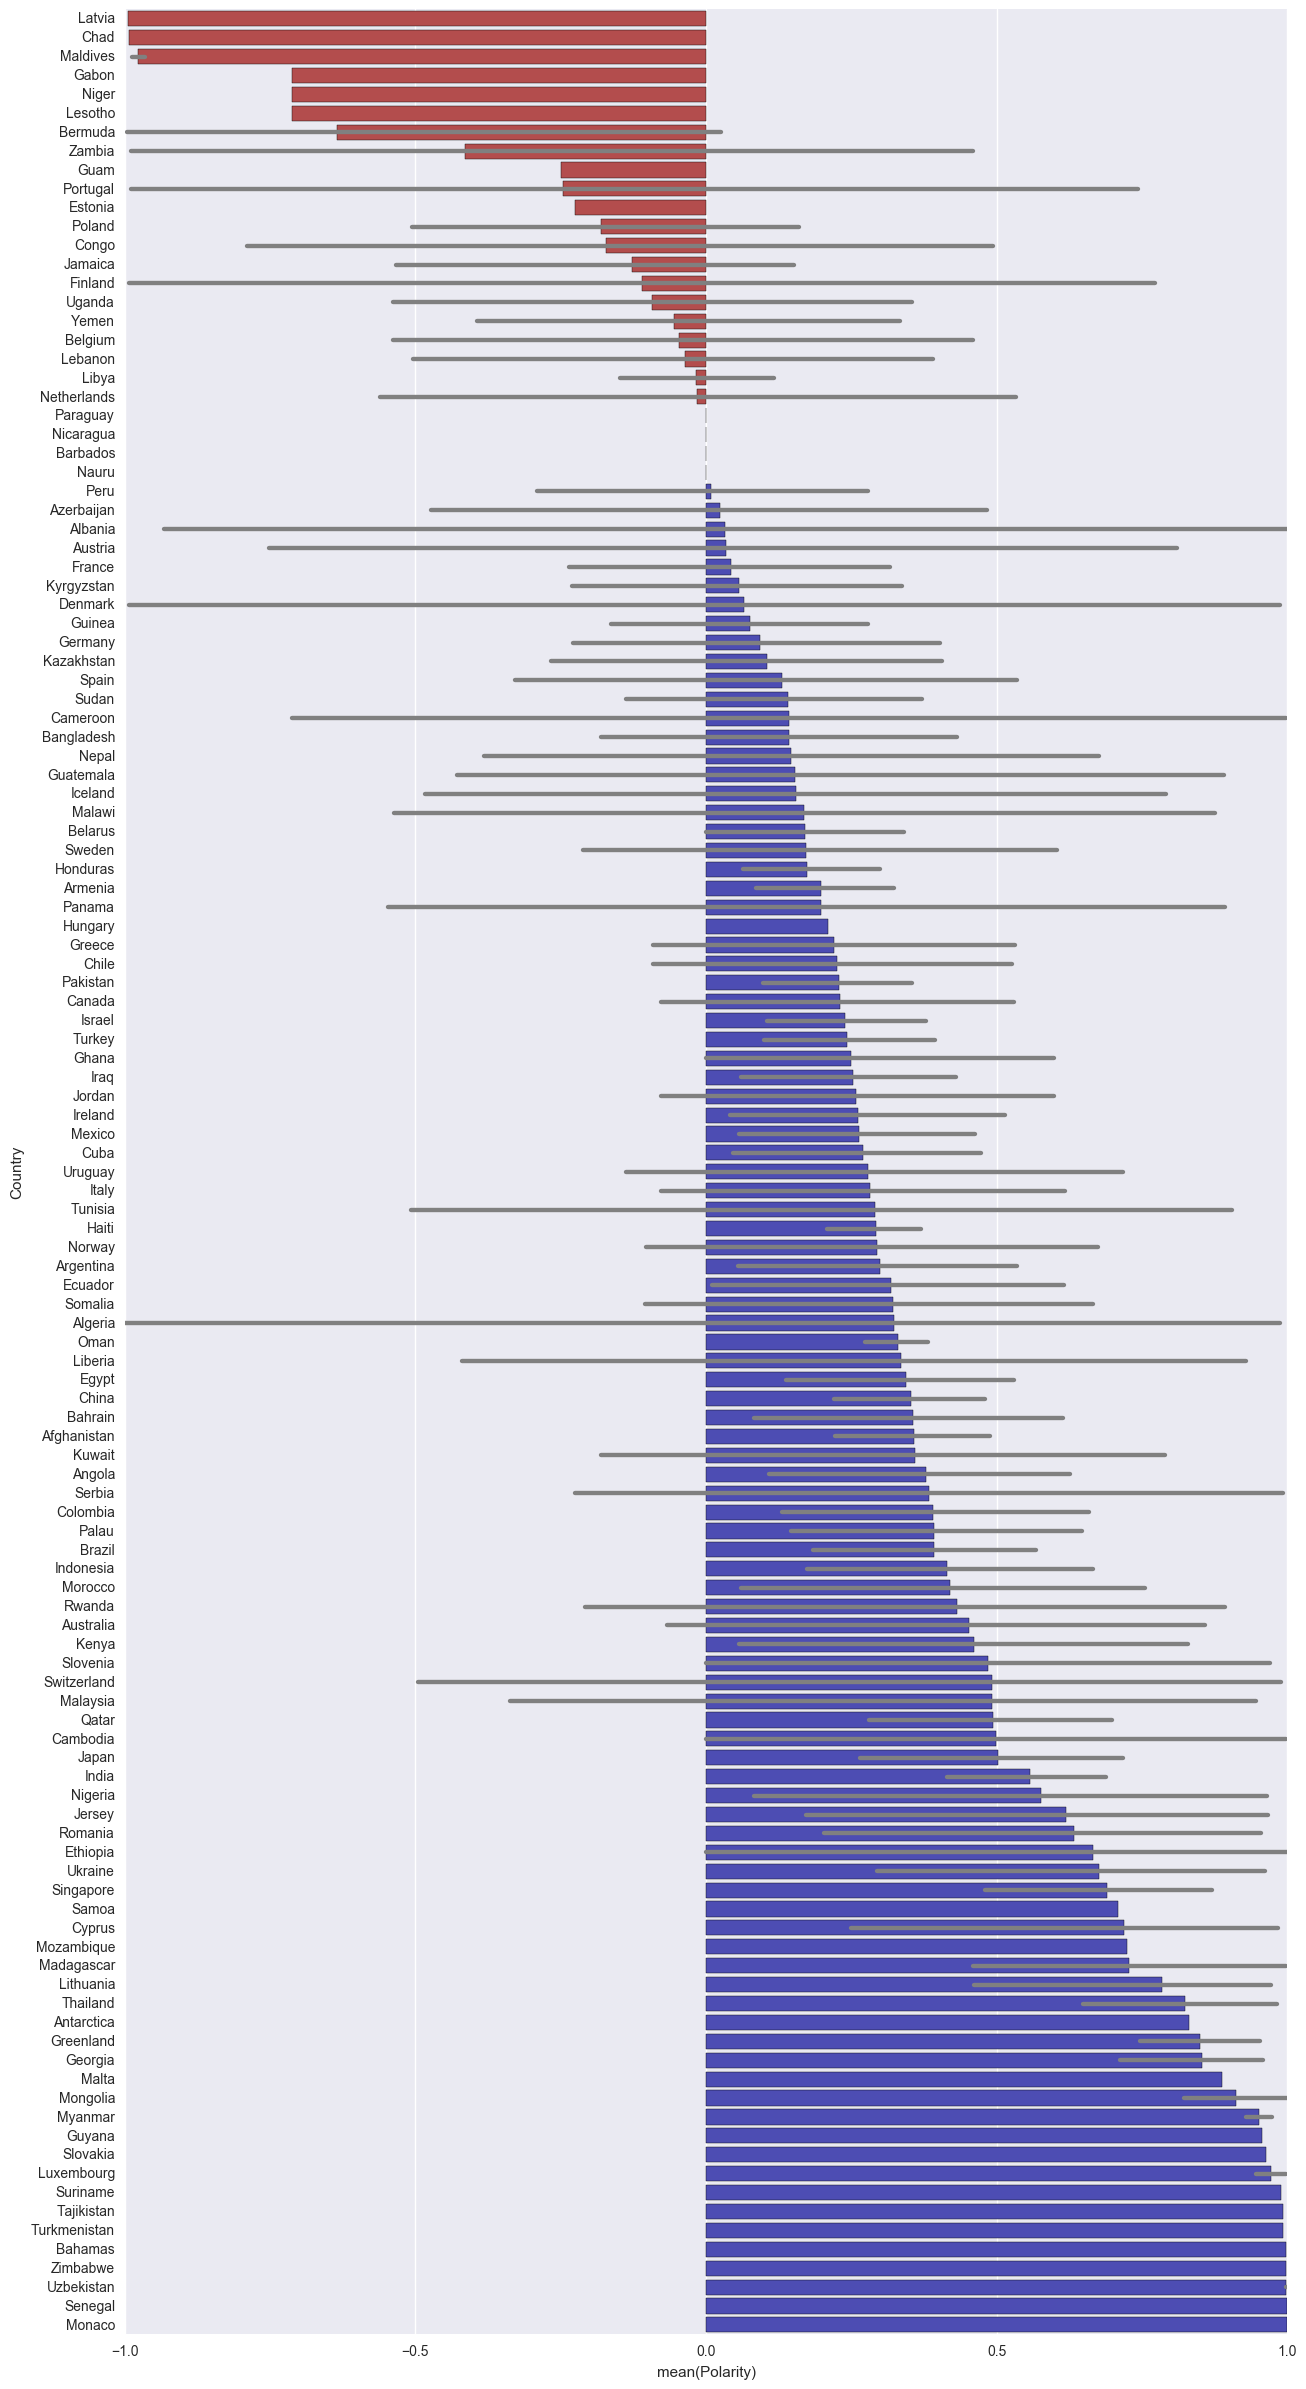

In [11]:
plt.subplots(figsize=(15,30))
sns.barplot(x='Polarity', 
            y='Country', 
            data=result, 
            order=sorted_values.index, 
            palette=colors, 
            saturation=.4, 
            errcolor='gray')
plt.show()

The plot shows the different average of sentiments per country. The gray part represents the standard deviation between each emails. A country with a big country would have a tendency to be _good_ or _bad_, other will tend to be only _good_ or _bad_.

### Part 3

Exploring the topics:

In [12]:
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


Let first construct a corpus. A corpus, in this case, is a ensemble of tuple $(i,n_i)$ where $i$ is the $i$th word and $n_i$ is the number of occurence of this word.

In [13]:
tokens = [run_pipeline(text) for text in extracted_emails.Text]
dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(t) for t in tokens]

By iterating over different `N_TOPICS` values, it appears that 15 seems to be a good value for this. 

Let constructs a new metric between a `n` topics discovery and a `n+1` topic discovery. First, we find the $n$ sets that have the higher jaccard similarity pairwise. Then take the average of all the paired jaccard similarities.

In [35]:
import time

def similarity(smallest_topics, biggest_topics):
    '''
    Compute a similarity of topics set based on Jaccard similarity. The idea is to group 
    together the set of words (topics) with the highest jaccard similarity. Then, 
    average the jaccard similarities of all these sets.
    
    `smallest_topics`: list of topics represented as set of words. Case for `n` topics.
    `biggest_topics`: Same as `smallest_topics` but with `n+1` topics.
    '''
    
    def jaccard(s1, s2):
        u = len(s1.union(s2))
        if u==0:
            return 0
        
        i = len(s1.intersection(s2))
        return i / u
    
    biggest_topics = list(biggest_topics)
    
    paired_topics = []
    for t1 in smallest_topics:
        highest_jaccard_topic = sorted(biggest_topics, key=lambda x: jaccard(t1, x), reverse=False)[0]
        biggest_topics.remove(highest_jaccard_topic)
        
        paired_topics.append((t1, highest_jaccard_topic))
        
    jaccards = [jaccard(s1,s2) for (s1,s2) in paired_topics]
    
    return sum(jaccards) / len(jaccards)

last_topics = None
similarities = []
running_times = []
for n_topics in range(5,51):
    start = time.time()
    lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary)
    duration = time.time() - start
    
    topics_list = lda.show_topics(num_topics=n_topics, num_words=20, formatted=False)
    new_topics = [{w for w,_ in topic} for (_,topic) in topics_list]
    
    if last_topics is not None:
        similarities.append(similarity(last_topics, new_topics))
        running_times.append(duration)
        
    last_topics = new_topics
    
similarities

[0.11563142089457878,
 0.05787974209026841,
 0.06540389435126277,
 0.08005118870993233,
 0.05519538749672908,
 0.0374378427010006,
 0.03950672371725003,
 0.0398576714366188,
 0.03284692353518264,
 0.02612299980721033,
 0.028557302241512768,
 0.024544534412955465,
 0.048233193197680546,
 0.05160804012713197,
 0.03074487839030775,
 0.032908429812454586,
 0.025084077715656662,
 0.020508731035046825,
 0.018252718481551435,
 0.019802190854822436,
 0.02067476383265857,
 0.022998083726828673,
 0.02124661773784581,
 0.017151394970943843,
 0.0116376323272875,
 0.01670415354625881,
 0.010103220629536417,
 0.013034795929532772,
 0.010918905655747763,
 0.017842150969085955,
 0.011997769892506735,
 0.00818767485434152,
 0.00569285775544666,
 0.005433624547197954,
 0.006828379298014924,
 0.005802968960863697,
 0.009688072589227917,
 0.006951138530085898,
 0.0005963029218843172,
 0.0017482517482517483,
 0.0011396011396011395,
 0.002229654403567447,
 0.005455537370430987,
 0.00430161943319838,
 0.0042

Let's now plot these values

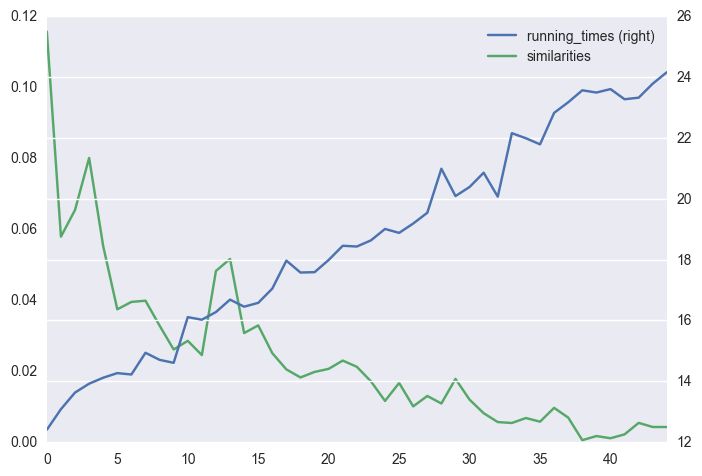

In [38]:
df = pd.DataFrame({'similarities': similarities, 'running_times': running_times})
ax = df.plot(secondary_y='running_times')
#ax2 = ax.twinx()

#ax2.set_label('Time in seconds')

This plot suggests that a good shot is at around 15-20. After that, the similarity doesn't improve a lot. Furthermore, the running time increase linearly with the number of topics. 

The running time are shown here in seconds, thus it takes quite some time to do the computation. The gain in similarity doesn't seem to justify the increase in running time.

Let choose 20 topics.

In [39]:
N_TOPICS = 20
lda = LdaModel(corpus, num_topics=N_TOPICS, id2word=dictionary)

In [40]:
for no in range(lda.num_topics):
    words = ' '.join([w for w, _ in lda.show_topic(no, topn=20)])
    print(no+1,':',words)

1 : republican obama bill health reform senate house campaign care new would industry time said congress right john public democratic party
2 : party mr one say company mcchrystal political labour said time tory un year charles new u last government american obama
3 : state u said obama house official clinton like new government president time would pressure may year one report department medium
4 : china woman year right would u one issue people new deal could american country also human state chinese way law
5 : obama president republican would white said new senator mr house blair democrat eu campaign american percent 2010 former clinton washington
6 : american boehner israel state party government peace one would year palestinian people u right leader republican said united obama group
7 : 2010 state gov h 1 cheryl 2 com clintonemail mill hrod17 sullivan 3 j 2009 huma 4 5 fyi abedin
8 : senate vote degree panel work else subcommittee burning republican fine democrat think ohio abu 

### Part 4 BONUS:

In [41]:
receivers = pd.read_csv('hillary-clinton-emails/EmailReceivers.csv', header=0, index_col=0)
senders = all_emails[['Id','SenderPersonId']]
senders = senders[pd.notnull(senders.SenderPersonId)]
percent = 100*len(senders)/len(all_emails)
print('%.2f' % percent, '% of emails have a valid sender.')

98.02 % of emails have a valid sender.


In [42]:
import community
import networkx as nx

G = nx.Graph()
for _, emailId, i in senders.itertuples():
    for _, emailId_2, j in receivers[receivers.EmailId == emailId].itertuples():
        assert emailId == emailId_2 # Check for coherence
        G.add_edge(int(i), int(j))
partitions = community.best_partition(G)

In [43]:
communities = {}
for k,v in partitions.items():
    emails = ' '.join(extracted_emails[all_emails.SenderPersonId == k].Text)
    if not v in communities:
        communities[v] = [emails]
    else:
        communities[v].append(emails)

In [44]:
from collections import Counter

for k,v in communities.items():
    text = ' '.join(v)
    tokens = run_pipeline(text)
    count = Counter(tokens)
    most = ' '.join(pd.DataFrame(count.most_common(20))[0]) if count else ''
    print(k+1,':',most)

1 : 
2 : 
3 : call state h w com gov hrod17 clintonemail u get time see know would 2009 thx talk 2010 pls print
4 : state u 2015 call would said agreement government united 1 benghazi department president work people case one house 4 subject
5 : state u woman said new clinton would one also time issue 2010 policy foreign year work think president government obama
6 : 
7 : woman said mr richards year say one new place people fisa life first time day city vote jamal foundation book
8 : un settlement people haitian e work government g latrine plan could though would need committee one au port prince least
9 : u call state talk ap want huma reuters gov said abedin mr abedinh 2009 would also h meeting today time
10 : state obama would u president one american 1 time said party new year republican 2009 house right 2010 2 government
11 : state 2015 u information department house subject agreement 13 would date waiver case redaction sensitive doc secretary comm benghazi f
12 : 
13 : 
14 : offi

We got 18 communities here and the subjects are not the same as the topic analysis.  
This was expected as the LDA model tries to figure out topics but here we only count word occurencies.
The most interesting fact is that we can clearly identify discussion topics here but it looks more unclear in the LDA model.